In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
measurement = Base.classes.measurement
stations = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [57]:
#read measurement table
df_m = pd.read_sql('SELECT * FROM measurement LIMIT 10', engine)
df_m

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


In [59]:
#read station table
df_s = pd.read_sql('SELECT * FROM station LIMIT 10', engine)
df_s

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [17]:
#check to see data type for 'date'
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
# Find the most recent date in the data set.
most_recent = pd.read_sql('SELECT MAX(date) FROM measurement', engine)
most_recent

,MAX(date)
0,2017-08-23


In [30]:
#alternative way to get max date
for day in session.query(func.max(measurement.date)):
    last_day = day
    print(last_day)

('2017-08-23',)


In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

#since we got the most recent date from above, we can hard code last years date
last_yr = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= last_yr).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_scores, columns = ['Date', 'Precipitation'])
# prcp_df.head(20) 
# --seems to already be sorted bc of order_by

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
5,2016-08-23,1.79
6,2016-08-23,0.70
7,2016-08-24,0.08
8,2016-08-24,2.15
9,2016-08-24,2.28


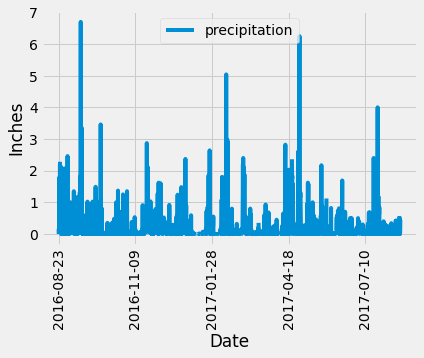

In [47]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot("Date", "Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(['precipitation'])
plt.xticks(rotation=90)
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [60]:
# Design a query to calculate the total number of stations in the dataset
session.query(stations).count()

9

In [95]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# SELECT station, count(station) FROM measurement GROUPBY measurement.station ORDER BY count desc ?

most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by((func.count(measurement.station)).desc()).all()
most_active

#for stats in most_active:
#    print(stats)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
#ma_stat = session.query(measurement).filter(measurement.station == 'USC00519281').all()

In [99]:
#min_stat = pd.read_sql('SELECT MIN(tobs) FROM measurement WHERE measurement.station == "USC00519281"', engine)
#min_stat

In [100]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    where(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [103]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
session.query(func.max(measurement.date)).filter(measurement.station == 'USC00519281').all()
last_yrs = dt.date(2017,8,18) - dt.timedelta(days=365)
#last_yrs
active_temp = session.query(measurement.tobs).filter(measurement.date >= last_yrs).\
    where(measurement.station == 'USC00519281').order_by(measurement.date).all()

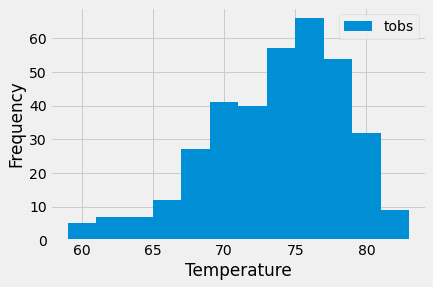

In [104]:
# Plot the results as a histogram
temp_df = pd.DataFrame(active_temp, columns=['tobs'])
temp_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(['tobs'])
plt.show()

# Close Session

In [105]:
# Close Session
session.close()